In [6]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.read_csv("../data/processed/daily_features.csv", parse_dates=['date'], index_col='date')
print(f"Данных: {len(df)} | {df.index.min().date()} → {df.index.max().date()}")

Данных: 1044 | 2022-01-15 → 2024-12-31


In [8]:
target = 'Vgas_m3'
features = [col for col in df.columns if col != target]

X = df[features].copy()
y = df[target].copy()

# Проверка перед обучением
print("Проверка данных:")
print("NaN в X:", X.isna().sum().sum())
print("inf в X:", np.isinf(X).sum().sum())
print("max abs:", X.abs().max().max())

# Разделение
train_mask = df.index.year <= 2023
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

print(f"Train: {len(X_train)} | Test: {len(X_test)}")

Проверка данных:
NaN в X: 0
inf в X: 0
max abs: 26980.0
Train: 691 | Test: 353


In [9]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=features)

In [10]:
xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb) * 100

print(f"XGBoost | MAE: {mae_xgb:,.0f} м³ | RMSE: {rmse_xgb:,.0f} | MAPE: {mape_xgb:.2f}%")

XGBoost | MAE: 1,302 м³ | RMSE: 2,062 | MAPE: 97.43%


In [11]:
prophet_train = pd.DataFrame({'ds': X_train.index, 'y': y_train.values})
prophet_test = pd.DataFrame({'ds': X_test.index})

regressors = ['air_temp_daily', 'air_temp_lag_1d', 'delta_T', 'T1_c_mean']
for col in regressors:
    prophet_train[col] = X_train[col].values
    prophet_test[col] = X_test[col].values

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
for col in regressors:
    m.add_regressor(col)

m.fit(prophet_train)
forecast = m.predict(prophet_test)
y_pred_prophet = forecast['yhat'].values

mae_p = mean_absolute_error(y_test, y_pred_prophet)
mape_p = mean_absolute_percentage_error(y_test, y_pred_prophet) * 100
print(f"Prophet | MAE: {mae_p:,.0f} м³ | MAPE: {mape_p:.2f}%")
import pickle
with open("../models/prophet_model.pkl", "wb") as f:
    pickle.dump(m, f)
print("Prophet модель сохранена: ../models/prophet_model.pkl")

10:08:06 - cmdstanpy - INFO - Chain [1] start processing
10:08:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet | MAE: 3,793 м³ | MAPE: 513.23%
Prophet модель сохранена: ../models/prophet_model.pkl


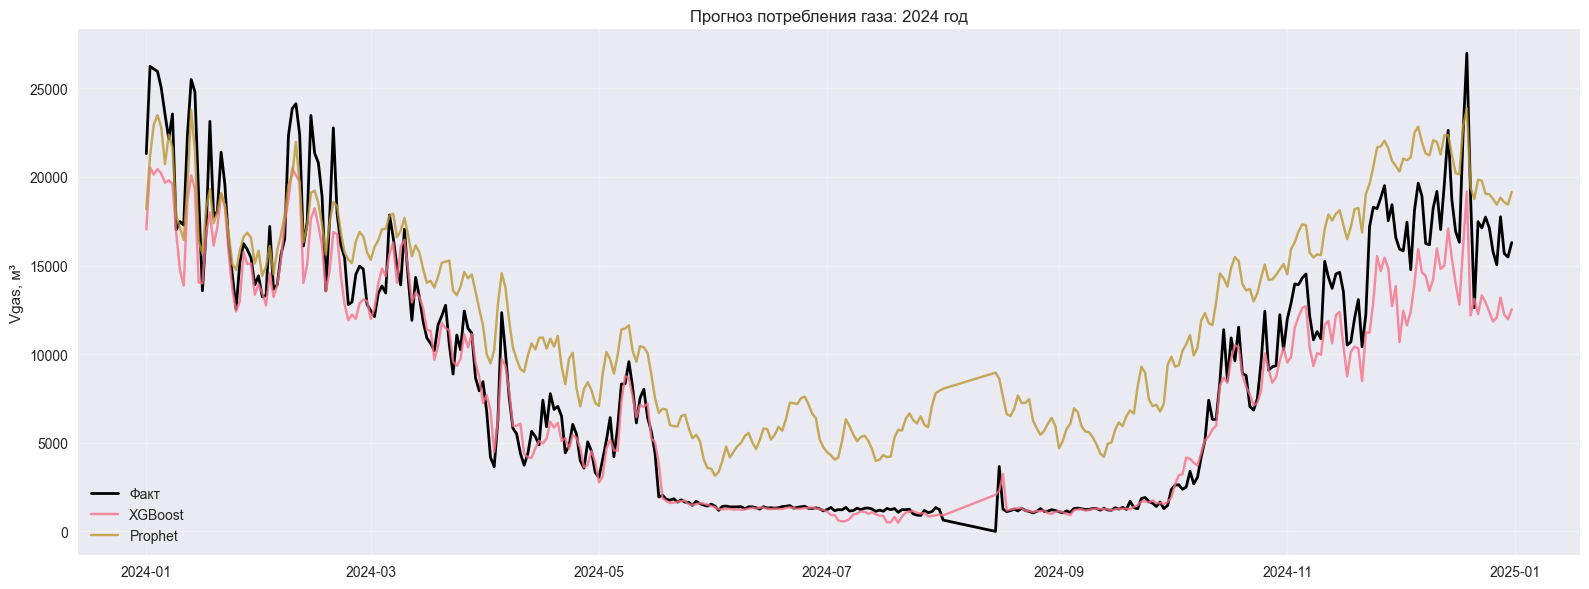

In [12]:
results = pd.DataFrame({
    'date': y_test.index,
    'actual': y_test.values,
    'XGBoost': y_pred_xgb,
    'Prophet': y_pred_prophet
}).set_index('date')

plt.figure(figsize=(16, 6))
plt.plot(results.index, results['actual'], label='Факт', linewidth=2, color='black')
plt.plot(results.index, results['XGBoost'], label='XGBoost', alpha=0.8)
plt.plot(results.index, results['Prophet'], label='Prophet', alpha=0.8)
plt.title('Прогноз потребления газа: 2024 год')
plt.ylabel('Vgas, м³')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

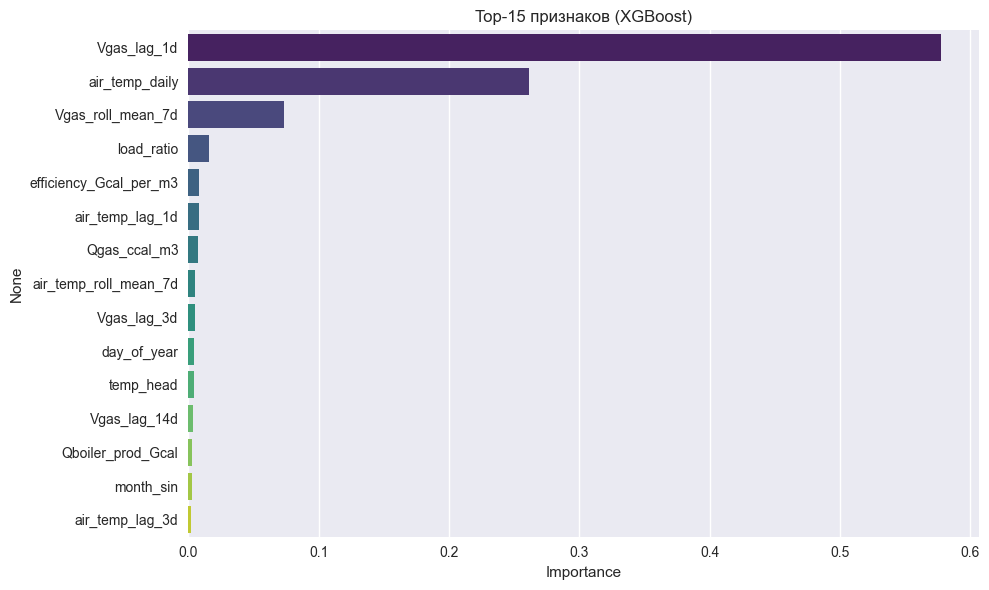

In [13]:
importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.values, y=importance.index, palette="viridis")
plt.title('Top-15 признаков (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [14]:
# Ячейка: Сохранение модели и скалера
import joblib
import os

os.makedirs("../models", exist_ok=True)

# Правильно: joblib.dump, а не allerlei
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(xgb, "../models/xgb_model.pkl")

print("Модель и скалер сохранены в папку ../models/")

Модель и скалер сохранены в папку ../models/
